# Preparing Xarray Data_array chunks to merge date and time

In [ ]:
from datetime import date
import os
from multiprocessing import Pool
import xarray as xr

data_file=os.listdir('Model_data_12km_2020/Model_data_12km_2020/')
date_time = []
rf=[]
count=0
chunks=[]
offset=56
for (e,data) in enumerate(data_file[229:]):
    print(f"Processing file {e+1}/{len(data_file)}: {data}")


#check if the file is a grib file
    if not data.endswith('.grib'):
        continue
    #print(data)
    full_path = os.path.join('Model_data_12km_2020/Model_data_12km_2020/', data)
    ds = xr.open_dataset(full_path, engine='cfgrib')
    for (v_t,tp) in zip(ds.valid_time.dt.strftime("%Y-%m-%d %H").values, ds['tp'].values):
        count=count+1
    
        v_t = str(v_t) 
        rf.append(tp)
        date_time.append(v_t)
      
    
    if (count>=1000 or data==data_file[-1]):
        da_chunk = xr.DataArray(
        rf,
        coords={'time': date_time, 'lat': ds.latitude.values, 'lon': ds.longitude.values},
        dims=['time', 'lat', 'lon']  # adjust dimensions as needed
        )
        counts=0
        #chunks.append(da_chunk)
        da_chunk.to_netcdf(f'rainfall_chunk_{e+offset}.nc')

        
    
# print(len(date_time)) 
# print(len(rf))
# rainfall_da = xr.concat(chunks, dim='time')

# # Wrap into an xarray Dataset
# ds_rain = xr.Dataset({'rainfall': rainfall_da})
# ds_rain.to_netcdf('rainfall_dataset.nc')
# # or for scalable analysis:
# # ds.to_zarr('rainfall_dataset.zarr', mode='w')

# print(ds_rain)

# Merging the Chunks to prepare Xarray Dataset

In [ ]:
ind=[31,33,35,36,37,38,39,40,41,42,43,44,45,55,76]

In [ ]:
import xarray as xr
ind=[14,31,33,35,36,37,38,39,40,41,42,43,44,45,55,76]
rainfall_da = None

for i in ind:
    print(f"Processing chunk {i}")
    chunk = xr.open_dataarray(f"rainfall_chunk_{i}.nc", chunks={'time': 100})

    if rainfall_da is None:
        rainfall_da = chunk
    else:
        rainfall_da = xr.concat([rainfall_da, chunk], dim='time')

print('Write directly to netcdf instead of keeping in memory')
rainfall_da = rainfall_da.sortby('time')
rainfall_da.to_netcdf('rainfall_dataset.nc')


# Open dataset and sort by time

In [1]:
import xarray as xr
ds_rf=xr.open_dataset('rainfall_dataset.nc')
ds_rf = ds_rf.sortby('time')
#ds_rf.to_netcdf('rainfall_dataset_sorted.nc')

# Visualisation of dataset

In [8]:
from torchvision.utils import save_image
from torchmetrics.regression import PearsonCorrCoef
from mpl_toolkits.basemap import Basemap
from eofs.standard import Eof
from torch import nn
import matplotlib.pyplot as plt

import netCDF4 as nc
import numpy as np
import torch

def plot_map(lon, lat, data, file_name):

    m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(ds_rf['lat'].to_numpy()), urcrnrlat=np.max(ds_rf['lat'].to_numpy()),
            llcrnrlon=np.min(ds_rf['lon'].to_numpy()), urcrnrlon=np.max(ds_rf['lon'].to_numpy()), )

    lons, lats = np.meshgrid(lon, lat)
    x, y = m(lons, lats)
    #levels = np.linspace(min(np.unique(data)),max(np.unique(data)),21)
    levels = np.linspace(min(np.unique(data)),15,21)
    temp = m.contourf(x, y, data, levels=levels, cmap='seismic')
    cb = m.colorbar(temp,"bottom", size="15%", pad="10%")

    m.drawcoastlines()
    m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(0., 361., 45.), labels=[0, 0, 0, 1])
    #plt.title('sst')
    #cb.set_label('sst')

    plt.savefig(file_name)
    plt.show()

# Mean of Subset of the Data

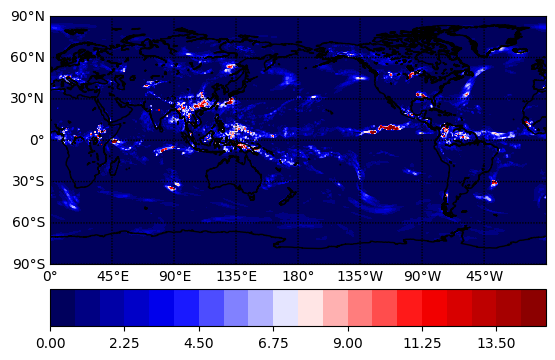

In [9]:

plot_map(ds_rf['lon'].to_numpy(),ds_rf['lat'].to_numpy(),ds_rf['__xarray_dataarray_variable__'][:100].mean(dim='time').to_numpy(),'file.png')

# Std of Subset of the Data

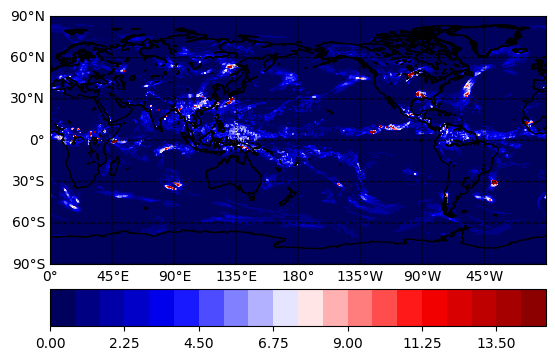

In [10]:
plot_map(ds_rf['lon'].to_numpy(),ds_rf['lat'].to_numpy(),ds_rf['__xarray_dataarray_variable__'][:100].std(dim='time').to_numpy(),'file.png')